In [27]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from fceu_help import pointer_to_numpy

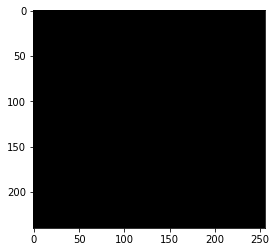

In [28]:
#rom = "mario.nes"

#movie = 'happylee4-smb-warpless.fm2'

# movie = "mario.fm2"
# start_t = 373
# rom = "metroid.nes"
# movie = "metroid.fm2"
# start_t = 518+39
#rom = "metroid.nes"
#movie ='lordtom-metroid-100.fm2'
#movie = "metroid-long.fm2"

rom = 'zelda.nes'
movie = 'baxter,jprofit22-legendofzelda.fm2'
#movie = 'zelda.fm2'
start_t = 0


# rom = "smb2u.nes"
# movie = "smb2u.fm2"
# start_t = 700
emu = fceulib.runGame(rom)
inputs1 = fceulib.readInputs(movie)
inputs2 = fceulib.readInputs2(movie)

for i,i2 in zip(inputs1[:start_t],inputs2[:start_t]):
    emu.stepFull(i, i2)
    
 
def convert_image(img_buffer):
    # TODO: without allocations/reshape?
    screen = pointer_to_numpy(img_buffer)
    return screen.reshape([256, 256, 4])[:240, :, :3].astype(np.uint8)
img_buffer = fceulib.VectorBytes()
np_image = np.zeros(shape=(240, 256, 1), dtype=np.uint8)
emu.imageInto(img_buffer)
np_image = convert_image(img_buffer)
plt.imshow(np_image)
plt.show()


    

NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
T: 0


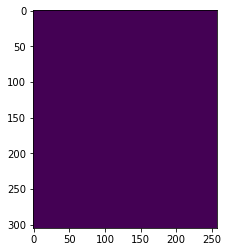

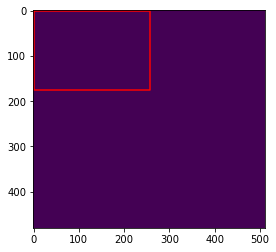

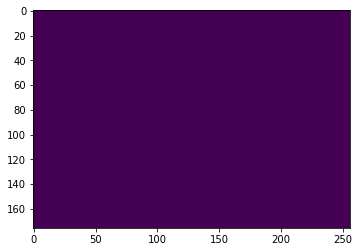

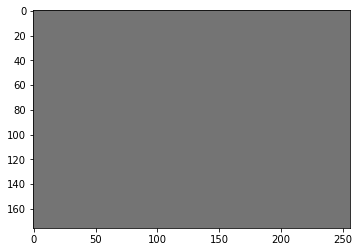

0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match

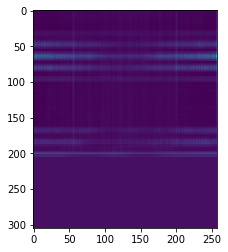

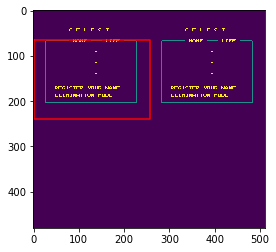

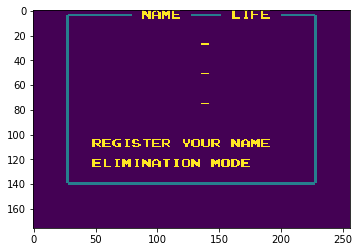

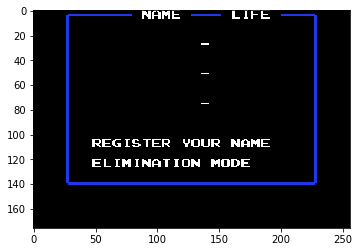

0 8 0 0 (0, 8)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 8 (0, -8)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0 0.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 0 (0, 8)
Matc

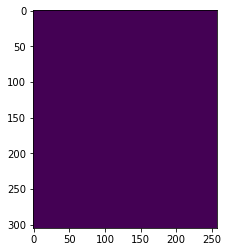

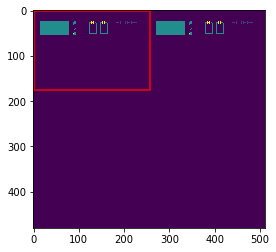

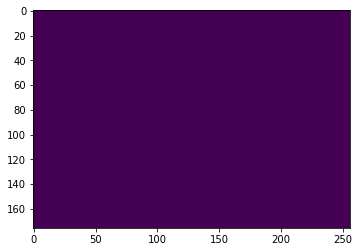

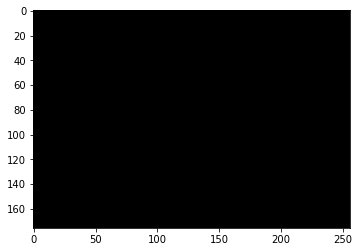

0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 0.0 0.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 0 (0, 8)
Match1 -0.0703249946237 1.0 (24, 0) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0703249946237 1.0 (24, 0) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0703249946237 1.0 (24, 0) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0703249946237 1.0 (24, 0) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.271164923906 0.682307720184 (24, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 8 (0, 0)
Match1 0.398213744164

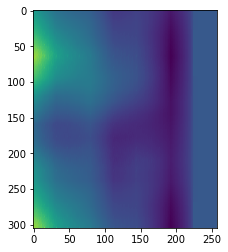

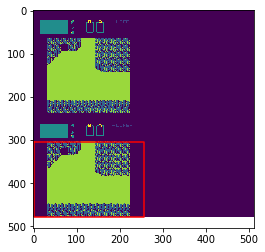

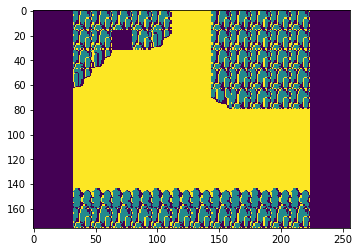

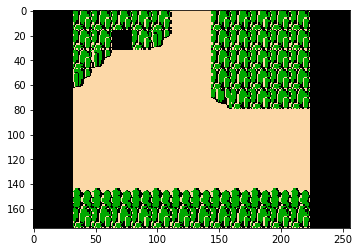

0 38 0 38 (0, 0)
Match1 0.416764438152 1.0 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.416764438152 1.0 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.416764438152 1.0 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.401451915503 0.939074516296 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 38 (0, 0)
Match1 0.358105570078 0.999999821186 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.358105570078 0.999999821186 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.358105570078 0.999999821186 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.358105570078 0.999999821186 (23, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.33362019062 0.9404327

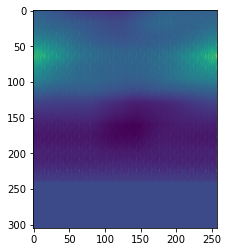

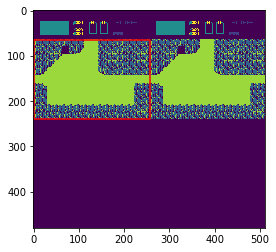

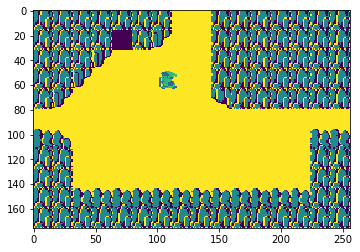

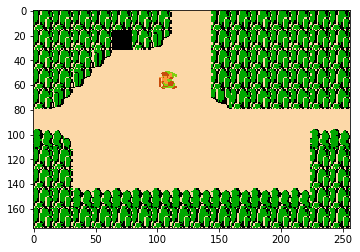

0 8 0 8 (0, 0)
Match1 0.288097083569 0.997752726078 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030028343 0.998619139194 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030296564 0.998618602753 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030296564 0.998619139194 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030564785 0.997891008854 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030296564 0.998618602753 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288100242615 0.997499644756 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288167268038 0.998651146889 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.

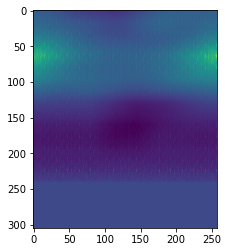

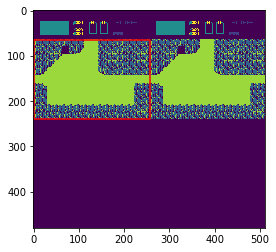

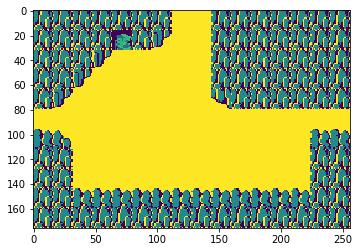

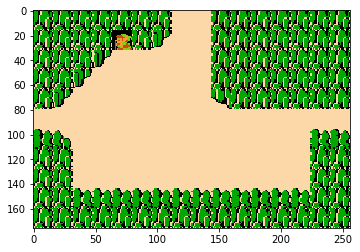

0 8 0 8 (0, 0)
Match1 0.297304809093 1.0 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.297728747129 0.998164892197 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.297503769398 0.998472809792 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.29736405611 1.0 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.29736405611 1.0 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.29736405611 1.0 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.297038525343 0.998602151871 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.296104848385 0.998449504375 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.296119868755 1.0 (22, 24) (8, 8)
Sc1 Offset: 0 

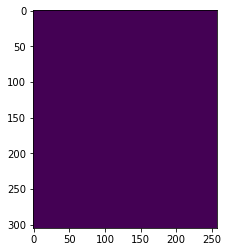

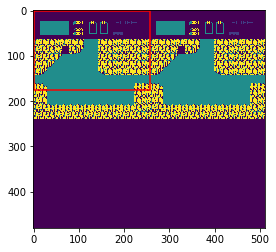

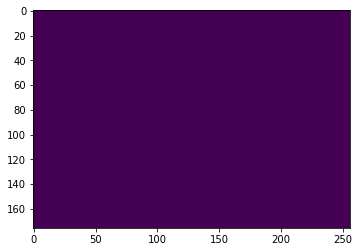

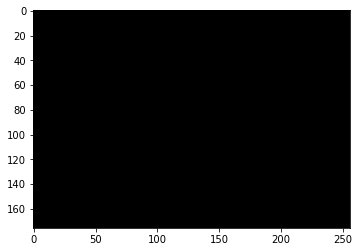

0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match1 1.0 1.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 0
0 0 0 0 (0, 0)
Match

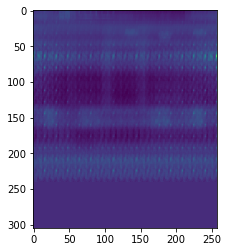

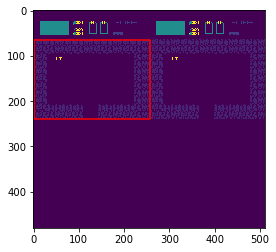

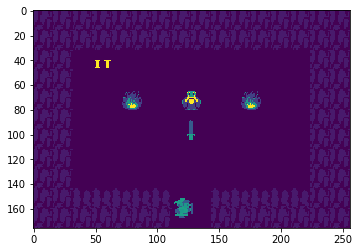

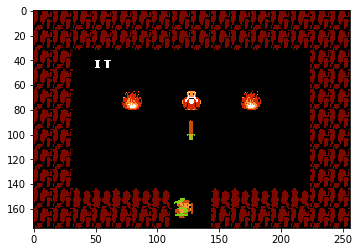

0 8 0 8 (0, 0)
Match1 0.0501300282776 0.987229943275 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0501300282776 0.987229704857 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0501300282776 1.0 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0497435107827 0.997170984745 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0498496219516 1.0 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0498496219516 1.0 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0498496219516 0.987295389175 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0498496219516 0.987295389175 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0498496219516 1.0 (21, 24

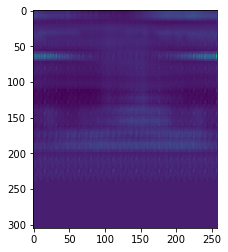

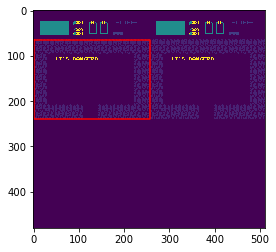

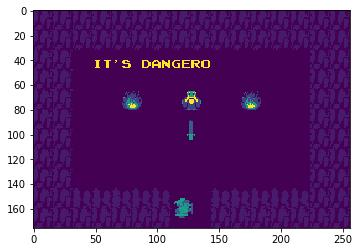

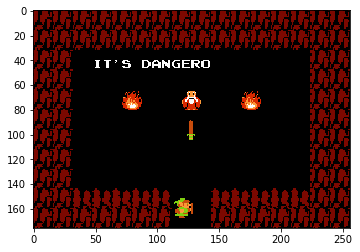

0 8 0 8 (0, 0)
Match1 0.0403827056289 0.990269124508 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0403827056289 0.990269124508 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0403827056289 1.0 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.03820470348 0.984634578228 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0386189818382 1.0 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0386189818382 1.0 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0386189818382 0.9905346632 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0386189818382 0.9905346632 (21, 24) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0386189818382 1.0 (21, 24) (8, 

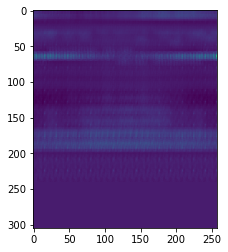

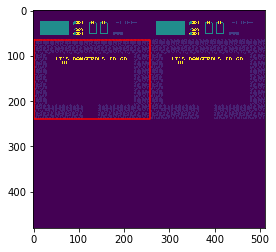

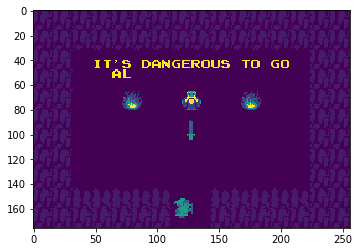

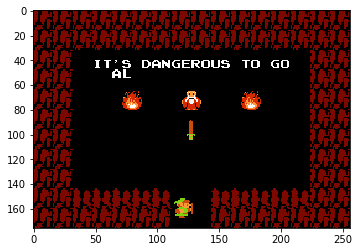

0 8 0 8 (0, 0)
Match1 0.0296748951077 0.991890907288 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0279149189591 0.991890907288 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0279149003327 1.0 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0260213669389 0.98671400547 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0241573117673 1.0 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0241573117673 1.0 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0241573117673 0.992079854012 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0258765183389 0.992079913616 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0258765555918 1.0 (20, 23)

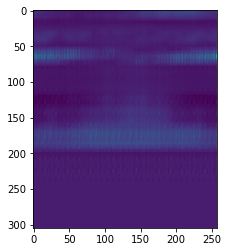

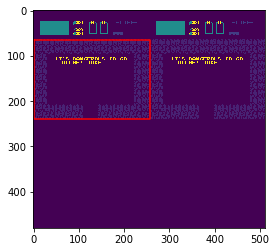

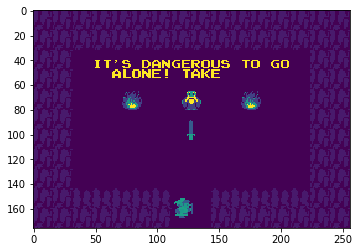

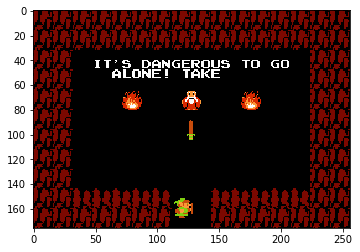

0 8 0 8 (0, 0)
Match1 0.00540770543739 0.993050217628 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.0038980206009 0.993050217628 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.00389803689905 1.0 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.00479353219271 0.993108391762 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.00387431192212 0.999999940395 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.00387431192212 0.999999940395 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.00387431192212 0.993133306503 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.005366015248 0.993133306503 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 

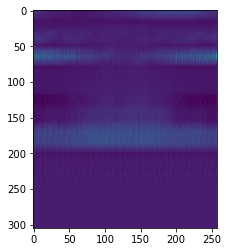

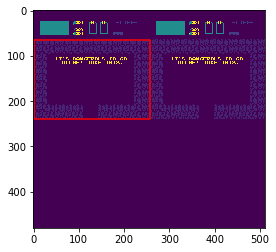

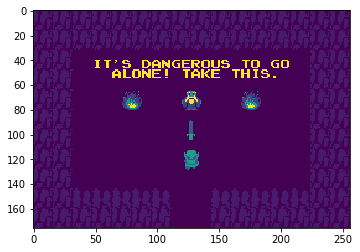

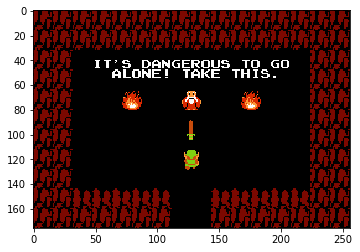

0 8 0 8 (0, 0)
Match1 -0.00550905661657 0.988353908062 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.00692109344527 0.988353908062 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.00716469436884 0.991006970406 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.00716467900202 0.9948117733 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.00716469436884 0.990810215473 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.00716467900202 0.994811892509 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.00709212198853 0.988689661026 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.00548761384562 0.988568663597 (20, 23) (8, 8)
Sc1 Offset: 0 0 0 0
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 

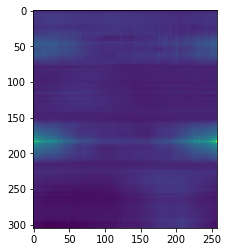

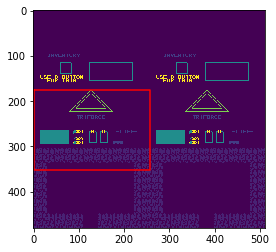

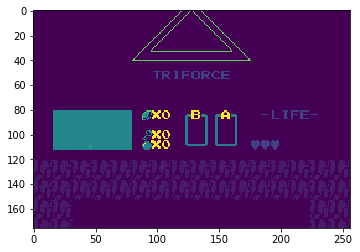

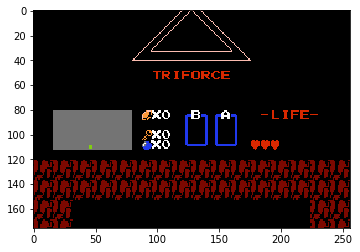

0 22 0 23 (0, -1)
Match1 0.10703741014 1.0 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -124
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 22
0 22 0 22 (0, 0)
Match1 0.106050997972 0.999999940395 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -127
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 22
0 22 0 22 (0, 0)
Match1 0.107429847121 1.0 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -130
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 21
0 21 0 22 (0, -1)
Match1 0.111237108707 0.999999940395 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -133
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 21
0 21 0 21 (0, 0)
Match1 0.116800457239 1.0 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -136
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 21
0 21 0 21 (0, 0)
Match1 0.12315710634 0.999999940395 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -139
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 20
0 20 0 21 (0, -1)
Match1 0.128416612744 0.999999940395 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -142
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 20
0 20 0 20 (0, 0)
Match1 0.132253974676 1.0 (21, 24) (8, 5)
Sc1 Offset: 0 -3 0 -145
NTS:
2 3 
0 1
M 0 base 2
Sc2: 0 19
0 19 0 20 (

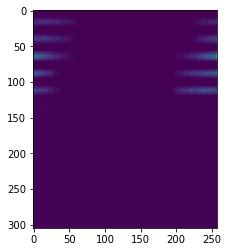

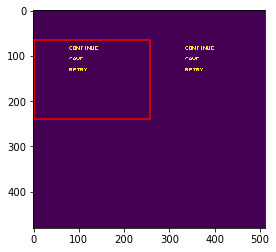

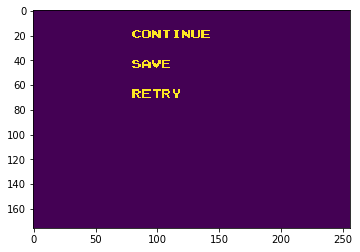

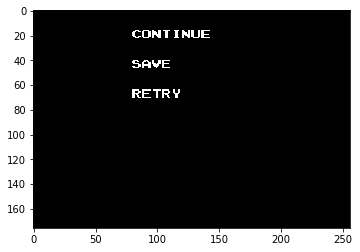

0 8 0 8 (0, 0)
Match1 -0.0132751129568 0.999999880791 (8, 1) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0132751129568 0.999999880791 (8, 1) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0113214580342 0.852833092213 (8, 0) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0102935219184 1.0 (8, 1) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0102935219184 1.0 (8, 1) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0102935219184 1.0 (8, 1) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0113214589655 0.852833092213 (8, 1) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0132751129568 0.999999880791 (8, 1) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.01327511

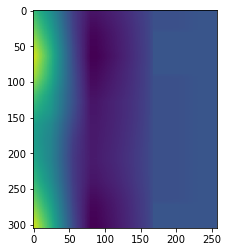

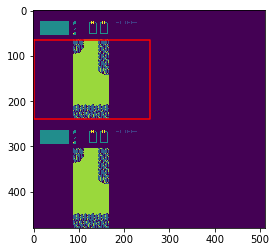

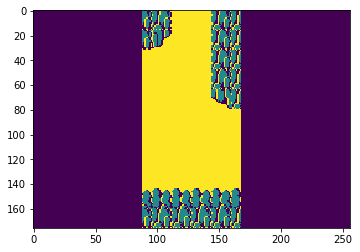

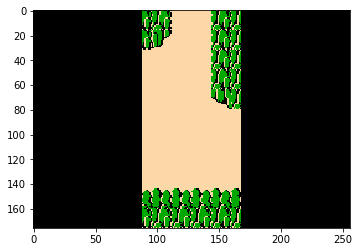

0 8 0 8 (0, 0)
Match1 0.61416298151 1.0 (24, 23) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.61416298151 1.0 (24, 23) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.645514845848 0.890141665936 (24, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.617952048779 0.999999880791 (24, 23) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.617952048779 0.999999880791 (24, 23) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.617952048779 0.999999880791 (24, 23) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.617952048779 0.999999880791 (24, 23) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.638799130917 0.898298382759 (24, 23) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 8 (0, 0)
Match1 

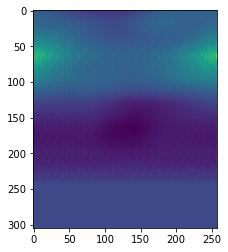

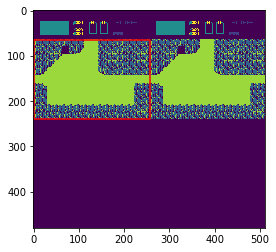

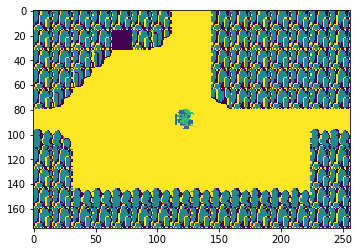

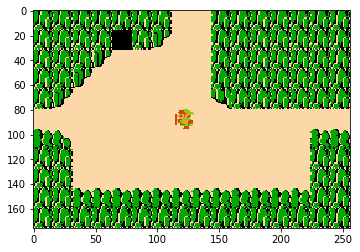

0 8 0 8 (0, 0)
Match1 0.288030296564 0.997890770435 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030296564 0.998619139194 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030564785 0.997890770435 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288030028343 0.998619139194 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288100510836 0.997499346733 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288166999817 0.998651444912 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288167536259 0.998651444912 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.288167268038 0.998651444912 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8


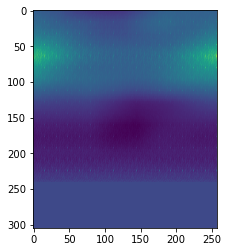

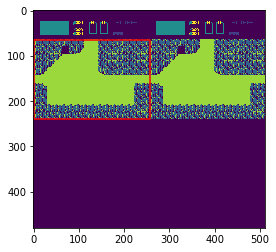

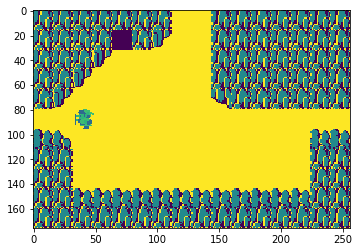

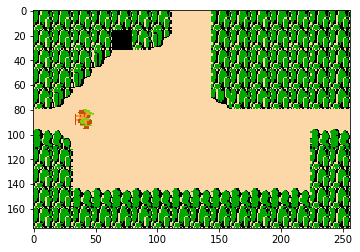

0 8 0 8 (0, 0)
Match1 0.291708797216 0.998619139194 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.291957199574 0.998619139194 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.292736500502 0.997890770435 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.293614327908 0.998619139194 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.293842673302 0.997499346733 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.294118851423 0.998651444912 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.294143140316 0.998651444912 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.294491201639 0.998651146889 (22, 24) (8, 8)
Sc1 Offset: 0 0 0 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8


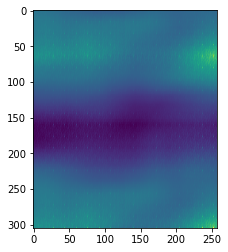

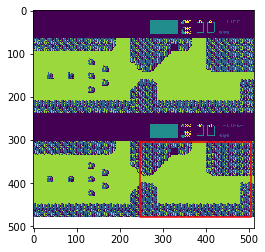

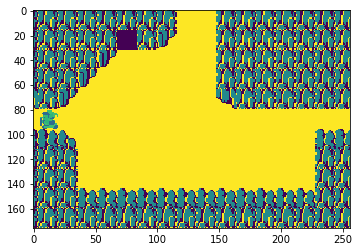

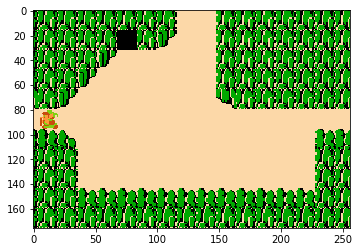

31 38 0 8 (-1, 0)
Match1 0.247438415885 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -8 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 31 38
31 38 31 38 (0, 0)
Match1 0.250890910625 0.997966885567 (24, 24) (4, 8)
Sc1 Offset: -4 0 -12 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 30 8
30 8 31 38 (-1, 0)
Match1 0.255778729916 0.999999940395 (24, 24) (4, 8)
Sc1 Offset: -4 0 -16 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 30 8
30 8 30 8 (0, 0)
Match1 0.260057300329 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -20 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 29 38
29 38 30 8 (-1, 0)
Match1 0.264841109514 0.999999761581 (24, 24) (4, 8)
Sc1 Offset: -4 0 -24 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 29 8
29 8 29 38 (0, 0)
Match1 0.273272901773 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -28 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 28 8
28 8 29 8 (-1, 0)
Match1 0.281334400177 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -32 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 28 38
28 38 28 8 (0, 0)
Match1 0.284862458706 0.997988045216 (24, 24) (4, 8)
Sc1 Offset: -4 0 -36 -175
NTS:
1 0 
3 2
M 1 b

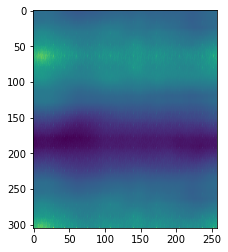

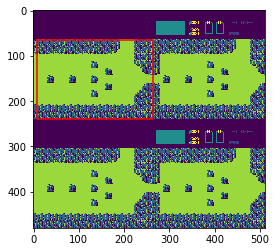

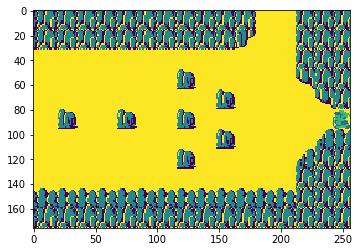

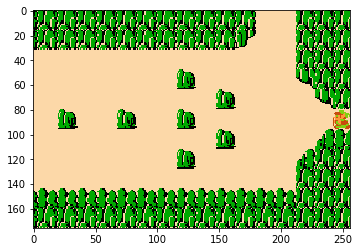

1 8 2 38 (-1, 0)
Match1 0.180150642991 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -248 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 1 8
1 8 1 8 (0, 0)
Match1 0.173731133342 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -252 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 0 8
0 8 1 8 (-1, 0)
Match1 0.169134348631 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -256 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188374146819 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188374146819 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188374146819 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188374146819 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188374146819 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188374146819 1.0 (20, 24) (8, 8)
S

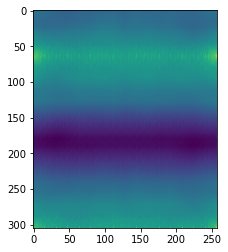

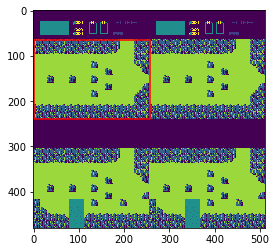

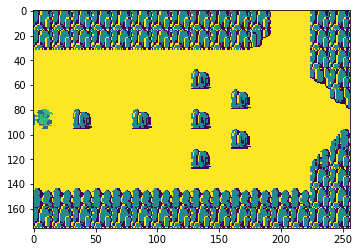

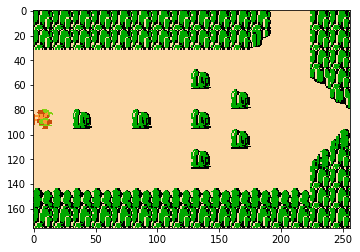

0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -256 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.188649117947 1.0 (20, 24) (8, 8)
Sc1 Off

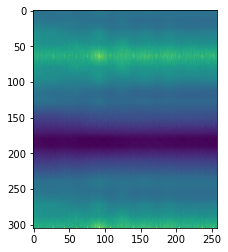

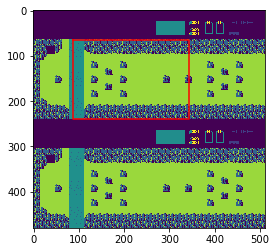

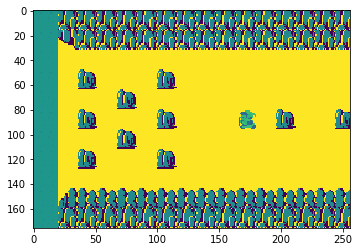

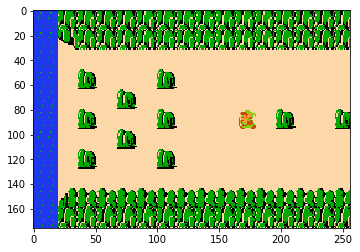

11 8 12 38 (-1, 0)
Match1 0.115721136332 1.0 (22, 24) (4, 8)
Sc1 Offset: -4 0 -424 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 11 8
11 8 11 8 (0, 0)
Match1 0.124366730452 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -428 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 10 8
10 8 11 8 (-1, 0)
Match1 0.153533771634 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -432 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 10 8
10 8 10 8 (0, 0)
Match1 0.18037994206 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -436 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 9 8
9 8 10 8 (-1, 0)
Match1 0.2025488168 0.997843563557 (22, 24) (4, 8)
Sc1 Offset: -4 0 -440 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 9 38
9 38 9 8 (0, 0)
Match1 0.185021594167 1.0 (22, 24) (4, 8)
Sc1 Offset: -4 0 -444 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 8
8 8 9 38 (-1, 0)
Match1 0.170292079449 0.999999821186 (22, 24) (4, 8)
Sc1 Offset: -4 0 -448 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 8 8
8 8 8 8 (0, 0)
Match1 0.157817289233 1.0 (22, 24) (4, 8)
Sc1 Offset: -4 0 -452 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 7 8
7 8 8 8 (-1, 0)
M

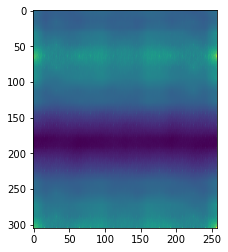

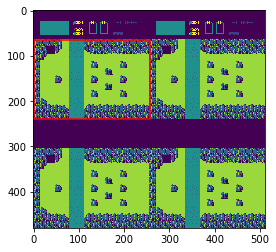

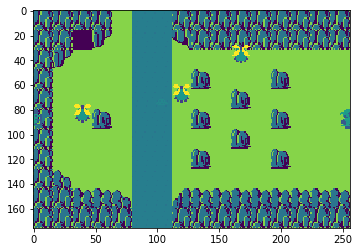

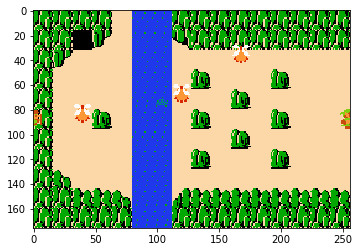

0 8 0 8 (0, 0)
Match1 0.159300729632 0.999999821186 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.159577146173 1.0 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.159577146173 0.999999821186 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.159395262599 0.990519404411 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.159029722214 0.999713003635 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.157866671681 0.993214309216 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.15263722837 0.999999880791 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.153225079179 0.990362524986 (23, 24) (8, 8)
Sc1 Offset: 0 0 -512 -175
NTS:
0 1 
2 3
M 0 base

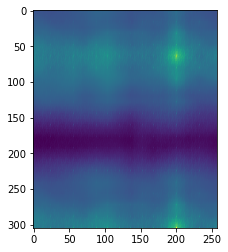

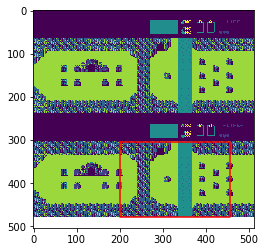

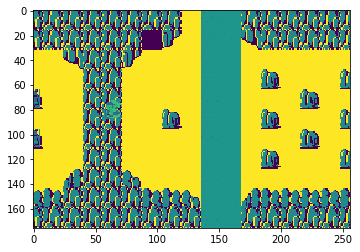

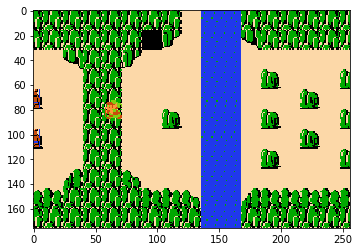

25 38 25 8 (0, 0)
Match1 0.115739494562 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -572 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 24 8
24 8 25 38 (-1, 0)
Match1 0.118597954512 0.998021900654 (24, 24) (4, 8)
Sc1 Offset: -4 0 -576 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 24 38
24 38 24 8 (0, 0)
Match1 0.118789888918 0.999999642372 (24, 24) (4, 8)
Sc1 Offset: -4 0 -580 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 23 38
23 38 24 38 (-1, 0)
Match1 0.120691038668 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -584 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 23 38
23 38 23 38 (0, 0)
Match1 0.124601989985 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -588 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 22 38
22 38 23 38 (-1, 0)
Match1 0.126180022955 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -592 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 22 38
22 38 22 38 (0, 0)
Match1 0.123004242778 1.0 (24, 24) (4, 8)
Sc1 Offset: -4 0 -596 -175
NTS:
1 0 
3 2
M 1 base 1
Sc2: 21 38
21 38 22 38 (-1, 0)
Match1 0.121970966458 0.998007237911 (24, 24) (4, 8)
Sc1 Offset: -4 0 -600 -175
NTS:
1 0 
3

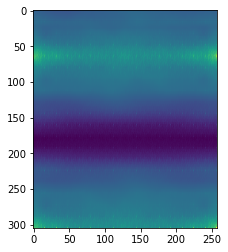

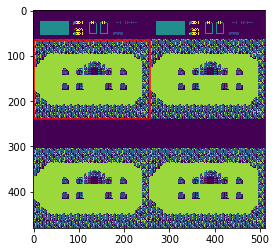

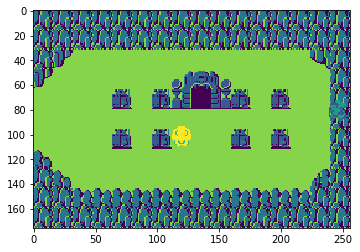

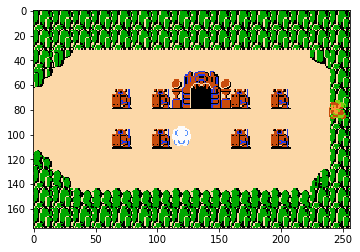

0 8 0 8 (0, 0)
Match1 0.158192247152 0.999407291412 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.157887086272 0.999287843704 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 38
0 38 0 8 (0, 0)
Match1 0.158460691571 0.998975276947 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.157840415835 0.999102771282 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 38 (0, 0)
Match1 0.158061355352 0.998655498028 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.157270103693 0.998960494995 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.157419681549 0.997882783413 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.156550660729 0.998704731464 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:

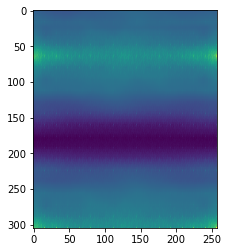

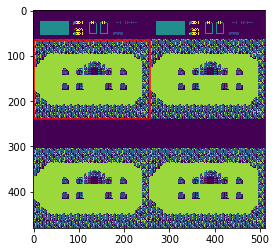

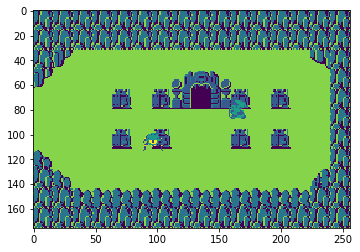

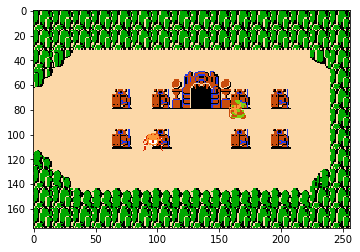

0 8 0 8 (0, 0)
Match1 0.157336011529 0.994868040085 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.156846210361 0.995928406715 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.156214669347 0.99618601799 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.15635997057 0.995860517025 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.156402245164 0.994957387447 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.157058209181 0.995836853981 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 38
0 38 0 8 (0, 0)
Match1 0.157893821597 0.99456256628 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 38 (0, 0)
Match1 0.158656895161 0.995867013931 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 


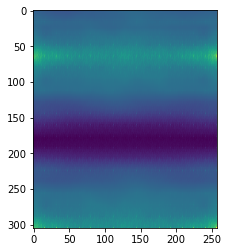

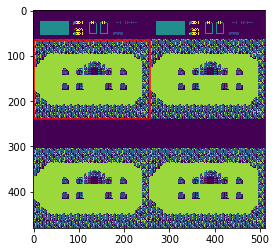

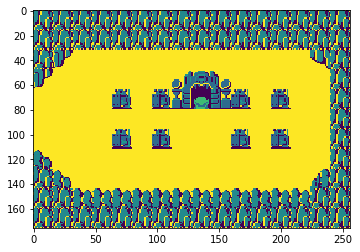

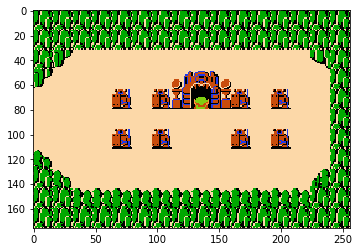

0 8 0 8 (0, 0)
Match1 0.155977129936 0.999056756496 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 38
0 38 0 8 (0, 0)
Match1 0.156341567636 0.999917268753 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.156265377998 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.156265377998 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.155953660607 0.999111771584 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 38 (0, 0)
Match1 0.156193464994 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.156193464994 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.156193464994 1.0 (20, 24) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Matc

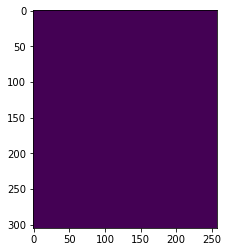

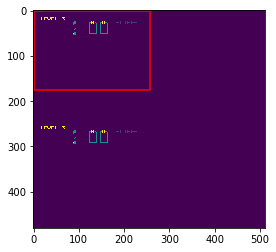

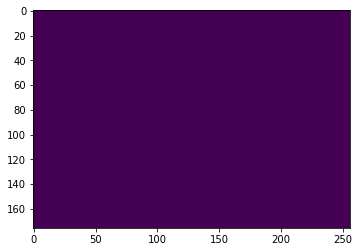

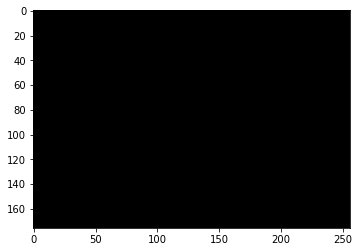

0 0 0 0 (0, 0)
Match1 0.0 0.0 (0, 0) (0, 0)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 0 (0, 8)
Match1 -0.0577170178294 0.999999940395 (24, 0) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 -0.0577170178294 0.999999940395 (24, 0) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 -0.0577170178294 0.999999940395 (24, 0) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 -0.0577170178294 0.999999940395 (24, 0) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 0.255984932184 0.684447705746 (23, 23) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 38 (0, 0)
Match1 0.317958772182 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 0.317958772182 1.0 (23, 23) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8

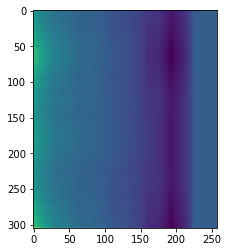

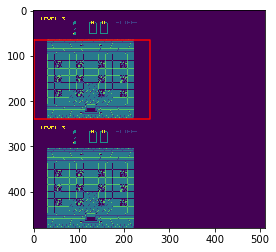

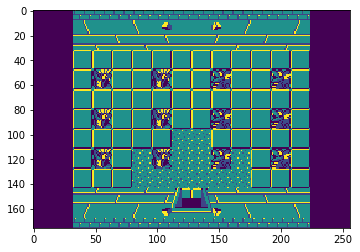

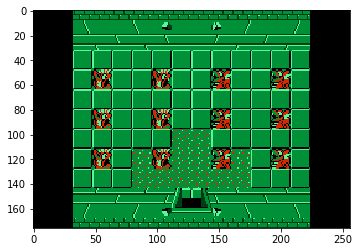

0 8 0 8 (0, 0)
Match1 -0.00442848587409 0.899085581303 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0686322078109 1.0 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0686322078109 1.0 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0686322078109 1.0 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.0686322078109 1.0 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.138316750526 0.896603226662 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 8 (0, 0)
Match1 -0.151970759034 1.0 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 -0.151970759034 1.0 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 1 base 0
Sc2: 0 38
0 38 0 38 (0, 0)
Match1 -0.151

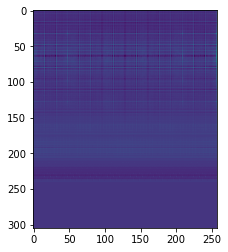

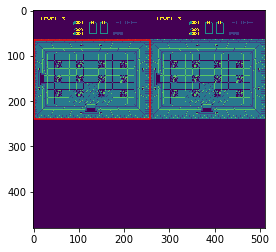

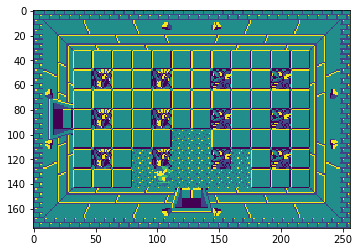

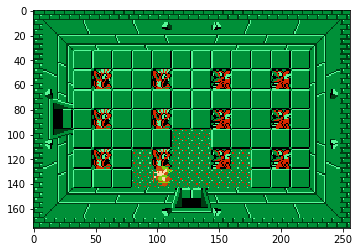

0 8 0 8 (0, 0)
Match1 -0.135494679213 0.993939399719 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.134613201022 0.990202784538 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.135305762291 0.99410122633 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.136078879237 0.989228904247 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.135699361563 0.994139552116 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.135285764933 0.994000256062 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.135675221682 0.99412548542 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.136083364487 0.99083006382 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3

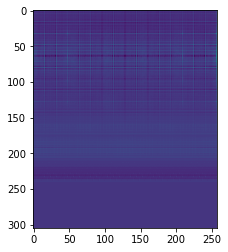

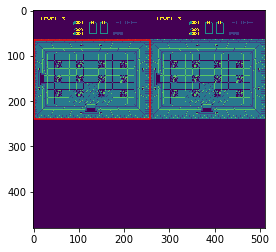

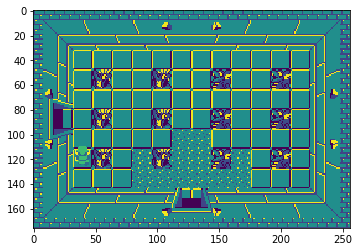

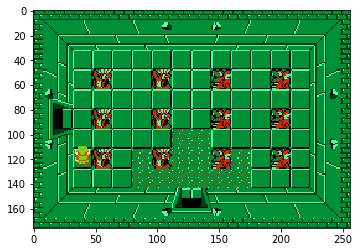

0 8 0 8 (0, 0)
Match1 -0.131569519639 0.995266199112 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.132652565837 0.992429375648 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.13307531178 0.995676517487 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.134726375341 0.992162823677 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.13555803895 0.995578706264 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.136041924357 0.995342731476 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.136886149645 0.995479106903 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 3
M 0 base 0
Sc2: 0 8
0 8 0 8 (0, 0)
Match1 -0.138511955738 0.992520153522 (23, 7) (8, 8)
Sc1 Offset: 0 0 -768 -175
NTS:
0 1 
2 

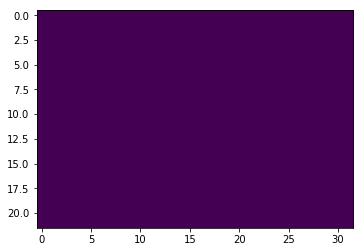

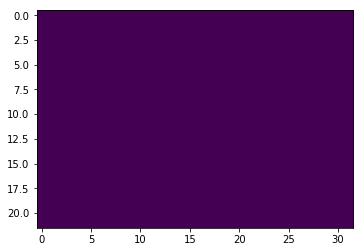

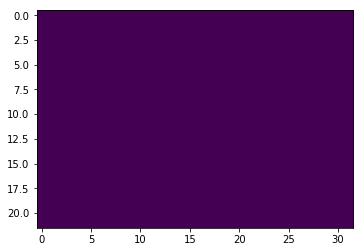

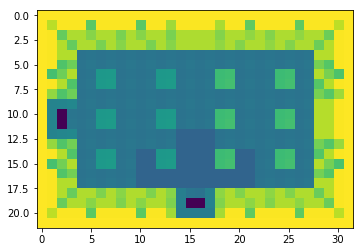

In [29]:
reload(ppu_dump)

end = 1800
#METROID
#scroll_area= (0,4,32,30-4)

#ZELDA
scroll_area= (0,8,32,30-8)

ep_data = ppu_dump.ppu_output(emu,
                              inputs1[start_t:end],
                              inputs2=inputs2[start_t:end],
                              bg_data=True,
                              scrolling=True,
                              sprite_data=True,
                              colorized_tiles=False,
                              display=False,
                              test_control=True,
                            scroll_area= scroll_area )

nt = ep_data["nametables"][0]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][1]
plt.imshow(nt)
plt.show()
nt = ep_data["nametables"][2]
plt.imshow(nt)
plt.show()

nt = ep_data["nametables"][-1]
plt.imshow(nt)
plt.show()

200 REGAINED CONTROL
390 REGAINED CONTROL
626 REGAINED CONTROL
738 REGAINED CONTROL
894 REGAINED CONTROL
1089 REGAINED CONTROL
1229 REGAINED CONTROL
1376 REGAINED CONTROL
1648 REGAINED CONTROL


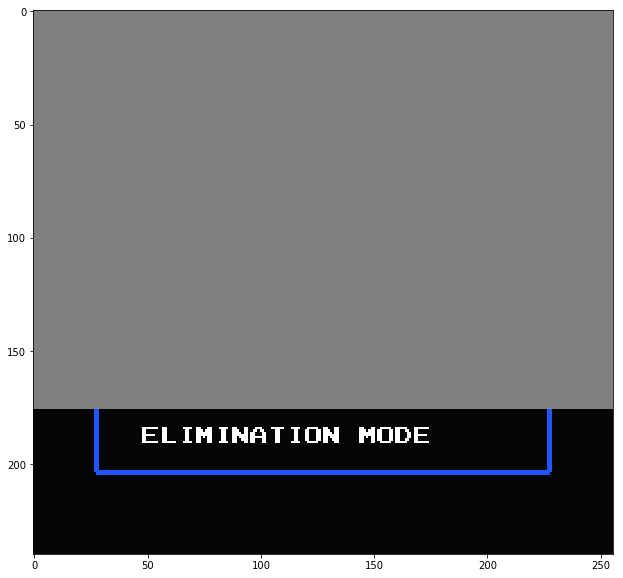

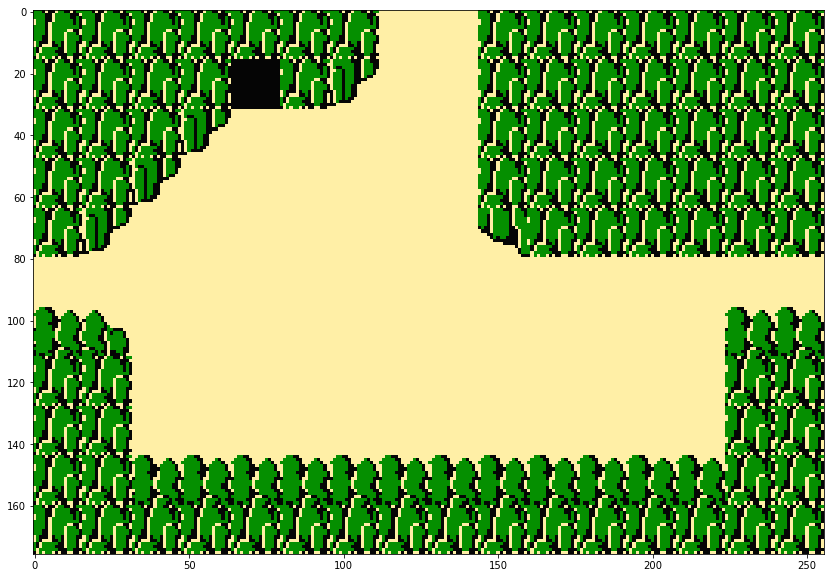

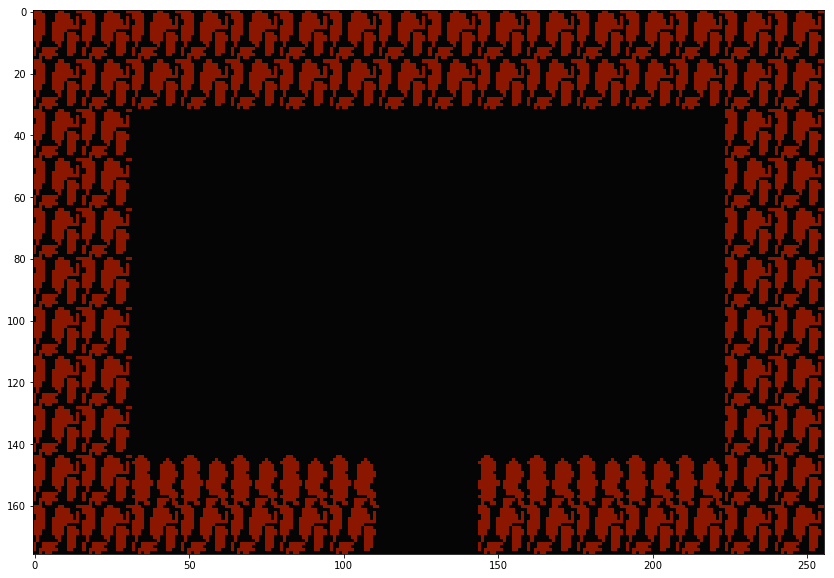

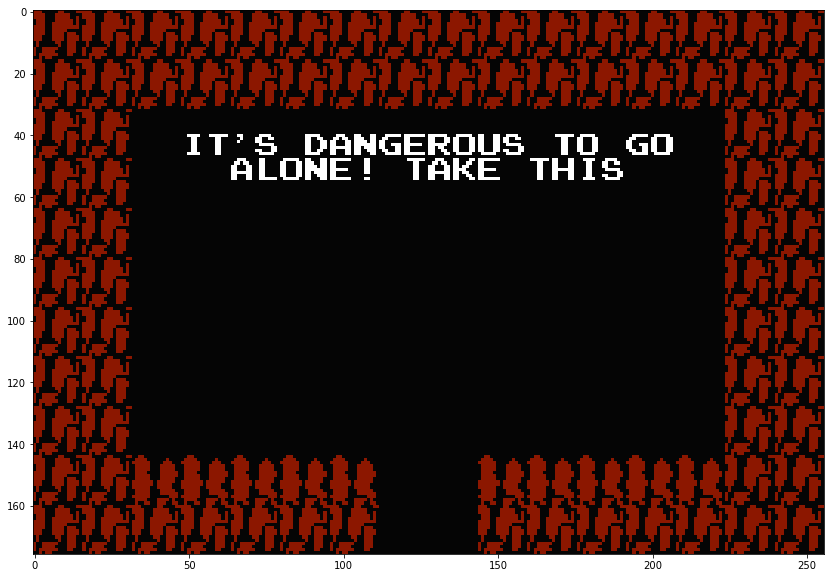

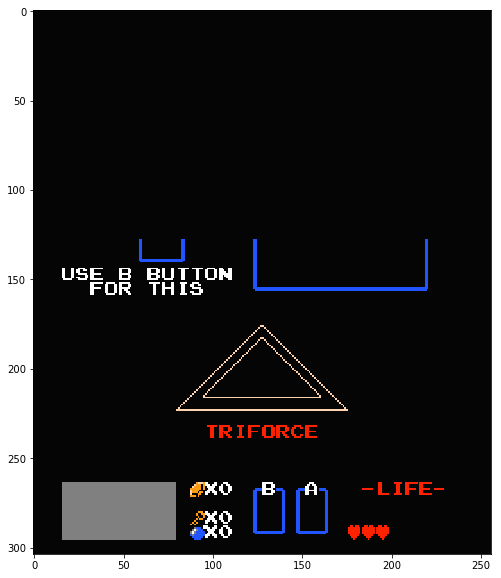

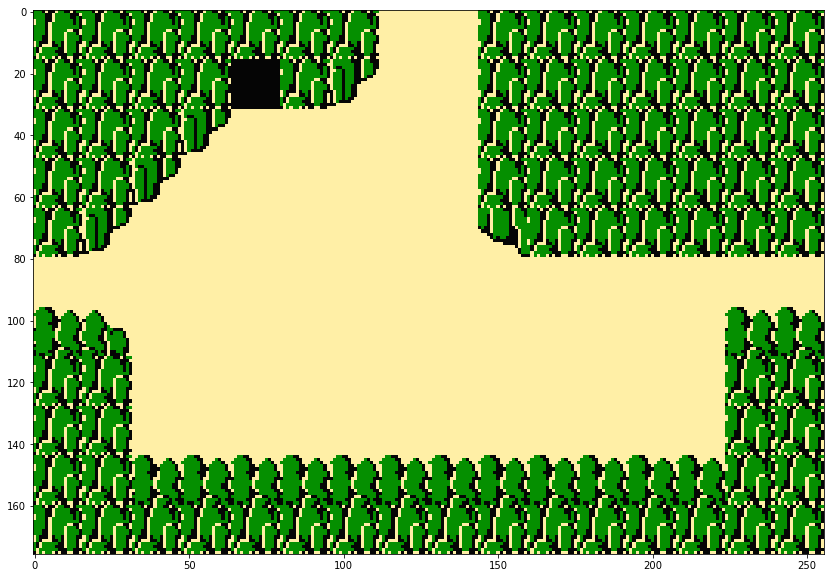

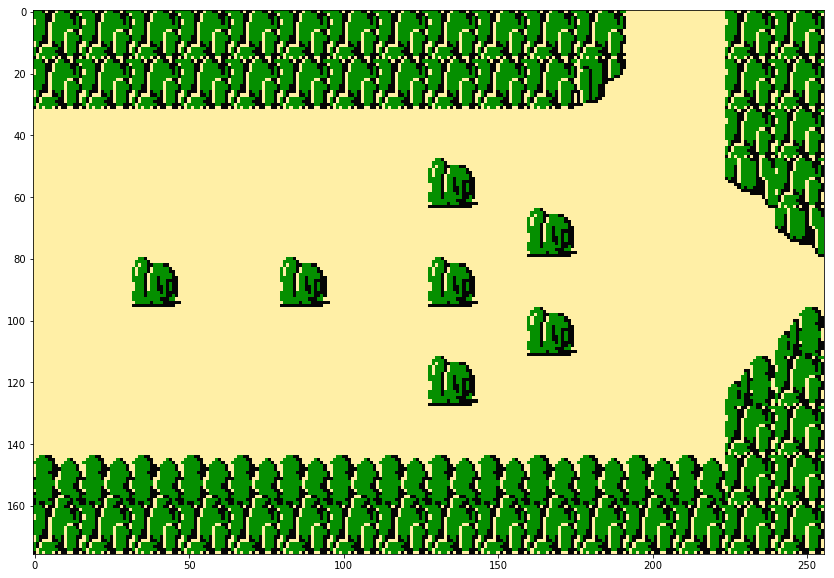

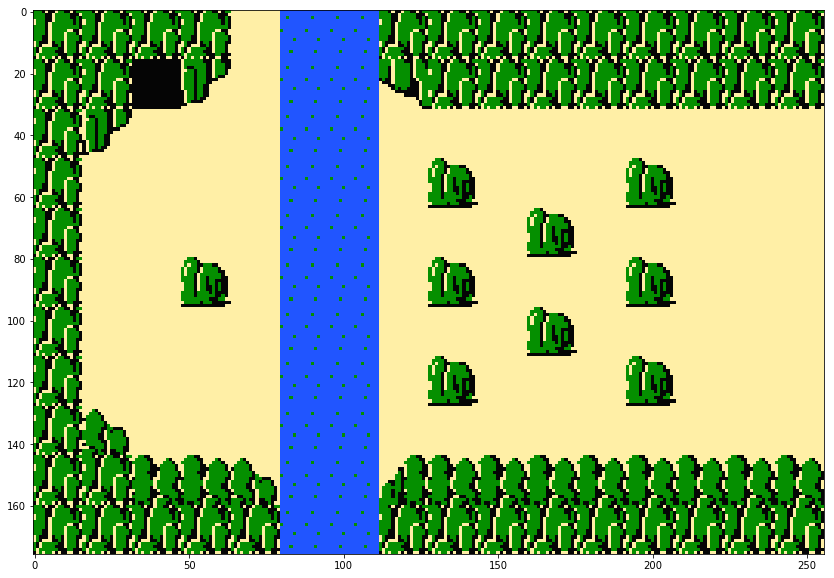

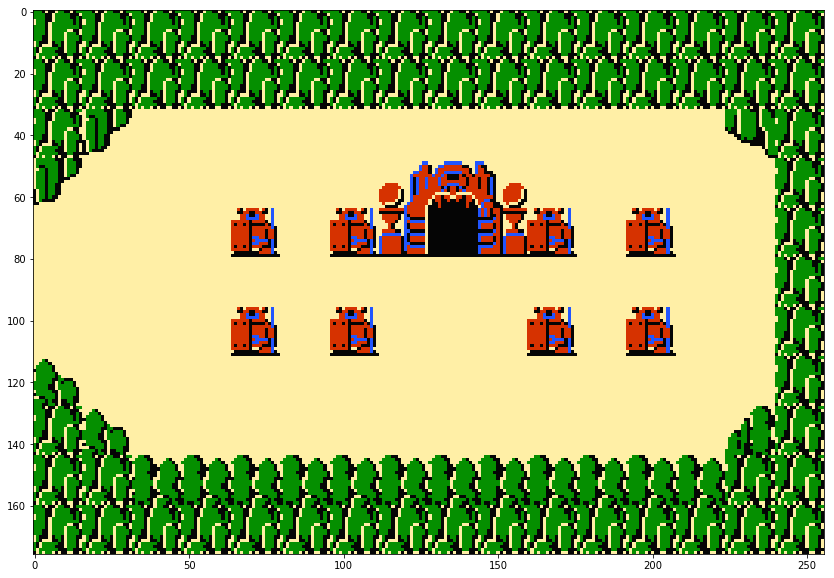

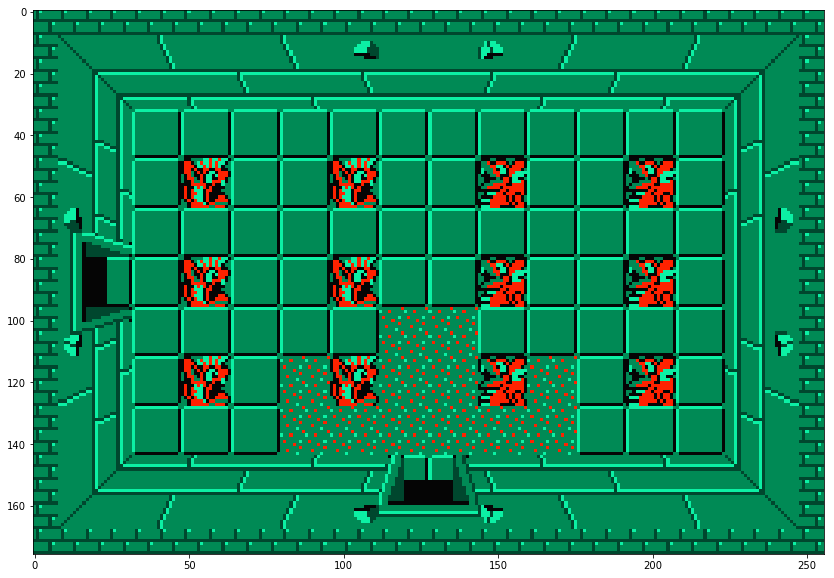

In [31]:
posx, posy = 0, 0
nt_total = {}
nt_totals = [nt_total]
tilex = 0
tiley = 0
interstitial = False

gap =60
big_gap = 90
timeSinceControl = 0
accum = 0
for t, (sx, sy) in sorted(ep_data["tilemap_motion"].items()):
    nt = ep_data["nametables"][t]
    attr = ep_data["attr"][t]
    pal = ep_data['palettes'][t]
    if sx >= 16:
        sx -= 32
    if sx <= -16:
        sx += 32
    if sy >= 15:
        sy -= 30
    if sy <= -15:
        sy += 30
    
    tilex += sx
    tiley += sy
    tiley = tiley % 30
    if not ep_data['has_controls'][t]:
        timeSinceControl += 1
    else:
        timeSinceControl  = 0
    if t > 4753 and t < 6500:
        print t, timeSinceControl, sx,sy
    if timeSinceControl > gap and ((sx != 0 or sy != 0) or timeSinceControl > big_gap):
        if not interstitial:
            #print t, timeSinceControl
            #plt.imshow(nt)
            #plt.show()
            pass
        interstitial = True
    #print t, timeSinceControl
    if ep_data['has_controls'][t] and interstitial:
        print t, 'REGAINED CONTROL'
        #plt.imshow(nt)
        #plt.show()
        interstitial = False
        nt_total = {}
        nt_totals.append(nt_total)
    #print t, timeSinceControl,interstitial
        
    if  ep_data['has_controls'][t]:
        #print "t", t, "scroll by", sx, sy, tilex, tiley
        for x in range(0, 32):
            for y in range(0, scroll_area[3]):
                key = (y+tiley, x+tilex)
                if key not in nt_total:
                    nt_total[key] = {}
                nt_total[key][t] = (int(nt[y, x]),int(attr[y, x]),pal)
    
for nt_id,nt_total in enumerate(nt_totals):
    if len(nt_total) > 0:
        minx = min(map(lambda (y, x): x,nt_total.keys()))
        maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
        miny = min(map(lambda (y, x): y,nt_total.keys()))
        maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
        nt_result = {}
        for x in range(minx, maxx):
            for y in range(miny, maxy):
                if (y,x) in nt_total:
                    nt_result[y-miny, x-minx] = nt_total[(y, x)]
        colorized = ep_data["tile2colorized"]
        out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
        for x in range(0, maxx-minx):
            for y in range(0, maxy-miny):
                col = np.zeros(shape=(8,8,3))
                if (y,x) in nt_result:
                    ind = sorted(nt_result[y, x])[0]
                    col = colorized[nt_result[y, x][ind]]
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
                out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
        plt.figure(figsize=(20,10)) 
        plt.imshow(out_image)
        plt.savefig('{}.png'.format(nt_id))
        plt.show()

In [33]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

In [34]:
def room2attr(room):
    
    minx = min(map(lambda (y, x): x,room.keys()))
    maxx = max(map(lambda (y, x): x,room.keys()))+1
    miny = min(map(lambda (y, x): y,room.keys()))
    maxy = max(map(lambda (y, x): y,room.keys()))+1
    attr_room = np.zeros((maxy-miny,maxx-minx,2))
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in room:
                ind = sorted(room[y, x])[0]
                attr_room[int(y-miny), int(x-minx),:] = np.array(room[(y, x)][ind][:-1])
    return attr_room
unions = UnionFind()

def dict_compare(d1, d2):
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())
    intersect_keys = d1_keys.intersection(d2_keys)
    added = d1_keys - d2_keys
    removed = d2_keys - d1_keys
    modified = {o : (d1[o], d2[o]) for o in intersect_keys if d1[o] != d2[o]}
    same = set(o for o in intersect_keys if d1[o] == d2[o])
    return added, removed, modified, same

for room_id,room in enumerate(nt_totals):
    for other_id,other in enumerate(nt_totals):
        if len(room) > 0 and len(other) > 0:
            if room2attr(room).shape == room2attr(other).shape:
                if np.sum(np.abs(room2attr(room)-room2attr(other))) == 0:
                    unions.union(room_id,other_id)

            
cluster2room = {}

for u in unions:
    if unions[u] not in cluster2room:
        cluster2room[unions[u]] = set()
    cluster2room[unions[u]].add(u)
print 'digraph G{\n\trankdir=LR;\npenwidth=10;\n'

for cluster in cluster2room:
    print '\tsubgraph cluster_{} {{'.format(cluster)
    print '\t\tcolor=blue;'
    for room in cluster2room[cluster]:
        print '\t\t n{}[image="{}.png", label="{}", fontsize=240,fontcolor=red];'.format(room,room,room);
    print '\t}'
for ii in range(1,len(nt_totals)):
    print 'n{} -> n{} [penwidth=10];'.format(ii-1,ii)
print '}'

digraph G{
	rankdir=LR;
penwidth=10;

	subgraph cluster_0 {
		color=blue;
		 n0[image="0.png", label="0", fontsize=240,fontcolor=red];
	}
	subgraph cluster_2 {
		color=blue;
		 n2[image="2.png", label="2", fontsize=240,fontcolor=red];
	}
	subgraph cluster_3 {
		color=blue;
		 n3[image="3.png", label="3", fontsize=240,fontcolor=red];
	}
	subgraph cluster_4 {
		color=blue;
		 n4[image="4.png", label="4", fontsize=240,fontcolor=red];
	}
	subgraph cluster_5 {
		color=blue;
		 n1[image="1.png", label="1", fontsize=240,fontcolor=red];
		 n5[image="5.png", label="5", fontsize=240,fontcolor=red];
	}
	subgraph cluster_6 {
		color=blue;
		 n6[image="6.png", label="6", fontsize=240,fontcolor=red];
	}
	subgraph cluster_7 {
		color=blue;
		 n7[image="7.png", label="7", fontsize=240,fontcolor=red];
	}
	subgraph cluster_8 {
		color=blue;
		 n8[image="8.png", label="8", fontsize=240,fontcolor=red];
	}
	subgraph cluster_9 {
		color=blue;
		 n9[image="9.png", label="9", fontsize=240,fontcolor=red];
	}
n

In [ ]:
for room_id, nt_total in enumerate(nt_totals):
    minx = min(map(lambda (y, x): x,nt_total.keys()))
    maxx = max(map(lambda (y, x): x,nt_total.keys()))+1
    miny = min(map(lambda (y, x): y,nt_total.keys()))
    maxy = max(map(lambda (y, x): y,nt_total.keys()))+1
    print room_id, (minx+maxx)/2, (miny+maxy)/2
    nt_result = {}
    for x in range(minx, maxx):
        for y in range(miny, maxy):
            if (y,x) in nt_total:
                nt_result[y-miny, x-minx] = nt_total[(y, x)]
    colorized = ep_data["tile2colorized"]
    out_image = np.zeros(shape=((maxy-miny)*8, (maxx-minx)*8, 4))
    for x in range(0, maxx-minx):
        for y in range(0, maxy-miny):
            col = np.zeros(shape=(8,8,3))
            if (y,x) in nt_result:
                col = colorized[nt_result[y, x].values()[-1]]
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, :3] = col/255.
            out_image[y*8:(y+1)*8, x*8:(x+1)*8, 3] = 1.0
    plt.figure(figsize=(20,10)) 
    plt.imshow(out_image)
    plt.savefig("{}.png".format(room_id),bbox_inches='tight')
    plt.show()